In [29]:
import sys
import subprocess
import json
import os
import platform
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML

# Hatchet Modeling Example

This is an example for using Hatchet's modeling feature. The modeling capability relies on _Extra-P_ - a tool for empirical performance modeling. It can perform N-parameter modeling with up to 3 parameters (N <= 3). The models follow a so-called _Performance Model Normal Form (PMNF)_ that expresses models as a summation of polynomial and logarithmic terms. One of the biggest advantage of this modeling method is that the produced models are human-readable and easily understandable. The modeling process creates a model out of an array of GraphFrames such that there is a model for row in the dataframe.

## Load Extra-P and Hatchet

In [30]:
# Add package dirs to PYTHONPATH
# deploy_dir = "./"
deploy_dir = "/g/g92/shudler1/projects/modeling/"
sys.path.append(deploy_dir + 'extrap/')   # ver 4.0.3
sys.path.append(deploy_dir + 'hatchet/')  # modified Hatchet (modeling capability)
sys.path.append(deploy_dir + 'Caliper/python/caliper-reader/')

import caliperreader as cr
import hatchet as ht

## Define datasets paths and names

In the example, we use datasets from LULESH and Kripke runs that are based on Caliper and HPCToolkit, respectively.

In [31]:
datasets = glob.glob('demo_perf_data/out_*.json')
datasets.sort()

## Load datasets into an array of GraphFrames

In [32]:
gframes = []
input_sizes = []
for dataset in datasets:
    gf = ht.GraphFrame.from_caliper_json(dataset)
    gf.drop_index_levels(np.max)
    n_sz = re.match('(.*)_(.*)_(\d+)(.*)', dataset).group(3)
    input_sizes.append(n_sz)
    gframes.append(gf)

## The first GraphFrame looks as follows

In [33]:
print(gframes[0].tree(depth=4))

    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v1.3.1a0

0.023 main
├─ 0.016 init
└─ 0.068 sort_arr

Legend (Metric: time Min: 0.02 Max: 0.07)
█ 0.06 - 0.07
█ 0.05 - 0.06
█ 0.04 - 0.05
█ 0.03 - 0.04
█ 0.02 - 0.03
█ 0.02 - 0.02

name User code    ◀  Only in left graph    ▶  Only in right graph



## Create models

First, we construct the Modeling object by passing all the relevant data to it. Then, we call `model_all` in that object.

In [34]:
mdl = ht.Modeling(gframes, input_sizes, 'Input sizes')
mdl.model_all()

## Models dataframe

In [35]:
mdl.models_df

,time_model
node,
"{'name': 'main', 'type': 'region'}",0.0023389999999999488 + 0.020376400000000003 *...
"{'name': 'init', 'type': 'region'}",0.00046939999999997693 + 0.015472799999999998 ...
"{'name': 'sort_arr', 'type': 'region'}",0.06776197967770152 + 0.04503396364483866 * p^...


## Query specific model

In our example, we want to retrieve a model for `MPI_Allreduce`. It means first finding a GraphNode whose name corresponds to that and then using this node as an index into the dataframe of the models. Note that we look for the desired GraphNode by traversing the modified first GraphFrame in the Modeling object (`mdl.gfs[0].graph`). This is important since the modeling process unifies the graphs and stores them in `mdl.gfs`.

In [36]:
node_list = [n for n in mdl.gfs[0].graph.traverse() if mdl.gfs[0].dataframe.loc[n, 'name'] == 'sort_arr']
model_exc = mdl.models_df.at[node_list[0], 'time_model']

## Operations on a model

### Evaluating the model given a value

In [25]:
model_exc.eval(60)

4.144692094085101

### Displaying the model

It returns a _figure_ and an _axis_ objects. The axis object can be used to adjust the plot, i.e., change labels.

In [26]:
fig, ax = model_exc.display()

Explicitly ask Matplotlib to show figures:

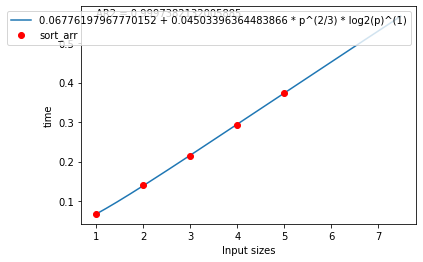

In [27]:
plt.show()

## Show the models dataframe with embedded plots

,time_model
node,
"{'name': 'main', 'type': 'region'}",
"{'name': 'init', 'type': 'region'}",
"{'name': 'sort_arr', 'type': 'region'}",

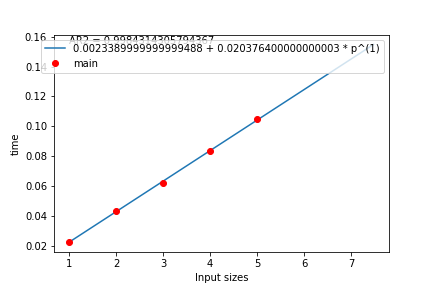
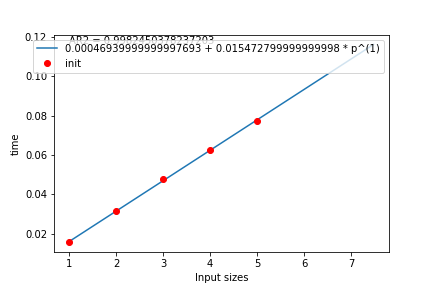
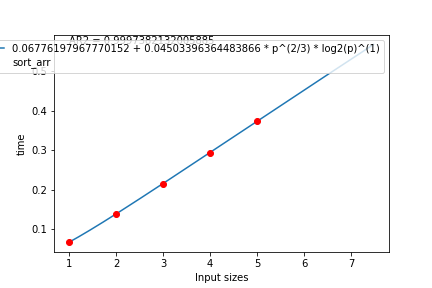

In [28]:
with pd.option_context('display.max_colwidth', -1):
    display(HTML(mdl.to_html()))